# Peak Integration and HPLC

In this work sheet, we will go through the process of analyzing chromatograms from analyte standards to make a calibration curve. Then we will use the calibration curve to find the concentration of the analyte in an unknown sample. For this assignment, **you will need to export your data as ASC files and save it in the same folder as this workbook.** 

Start by running the following code to import the libraries we need. The two libraries we are going to use are Numerical Python (NumPy) and the MatPlotLib PyPlot library. For simiplicity, we import the numpy library as np, so we can quickly access numpy functions by typing np.function(). Similarly, we import matplotlib.pyplot as plt. 

A note on Jupyter Notebooks: Jupyter Notebooks are awesome because you can intersperse text (like this) with blocks of code (like the block below). To run the code in the block, select the block and push **Shift+Enter or Ctrl+Enter**. If you tell it to print or plot something, it will print or plot the result below the code block. If you don't, like below, it will likely not show anything. If you get an error, it will tell you the type of error and the location. Once you have run a block of code, it is in the memory, and you don't need to rerun it. All the variables are globally saved and can be used in further code blocks. This can sometimes cause confusion/errors if you forget to run a code block that is required below or overwrite a variable. Two tips: First, if you get stuck, try clicking Cell > Run All Above, which runs all code blocks above the current one. This will help make sure all the libraries are imported and variables are defined. Second, try to avoid circular programming where you are constantly jumping back and forth between codeblocks and changing things. The best practice is to use unique variables for everything and a linear flow of logic so that the code can be run from top to bottom and work correctly.

In [20]:
import numpy as np
import matplotlib.pyplot as plt

Next, we need to import the data from the ASC file. We will use the numpy loadtxt function. We have to add some extra options to only extract the data we want from the file. 

After importing the raw detector voltage data from the ASC file, we need to generate the x-axis, which is time. Unfortunately, the time isn't encoded in the data. However, it does tell us that we are using a 5 Hz sampling rate. Therefore, we use the np.arange function to create a list of equally spaced data (0, 1, 2, 3, etc.), divide that by the 5 Hz sampling rate (0, 0.2, 0.4, 0.6, etc.) to create a time axis in seconds. We divide that by 60 to get the time axis in minutes. 

Armed with the x and y data (time and intensity), we can plot that with the plt.plot() function.

Syntax Note: Everything with a # at the beginning of the line is a comment. This is meant to help explain the code, but the program will not run it.

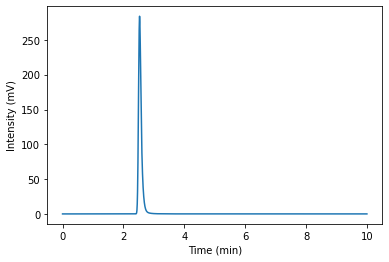

In [6]:
# First, specify your file name.
# IMPORTANT: This file needs to be in the same folder as your ipynb file
file1 = "20 uM caf trial 3ch 01.ASC"

# Now, we import the data and save it as ydata1
# skiprows tells the software to ignore the first 25 rows of metadata
# usecols tells it to only import the first column of data (the zero index)
# delimiter tells it that the data is separated by a comma
# comments tells it that the weird IPOINT data at the end can be ignored\
ydata1 = np.loadtxt(file1, skiprows=25, usecols=0, delimiter=",", comments="I")
# The data is read in microvolts, so we need to divide by 1000 to get mV
ydata1 = ydata1 / 1000.

# We next need to generate the x-data based on the sampling rate
rate = 5.0
xdata1 = np.arange(0, len(ydata1))/float(rate)/60.

#Plot the results
plt.plot(xdata1, ydata1)
plt.xlabel("Time (min)")
plt.ylabel("Intensity (mV)")
plt.show()

Let's cut out of some of the extra data to take a closer look at just the region around 2-3 minutes.

We will start by defining a function called datachop. Datachop takes four arguments, 1) the x data, 2) the y data, 3) the minimum x value, and 4) the maximum x value. It returns two outputs, the cut x data and the cut y data. Don't worry too much about how the function works, but basically, it choses all the data the is both greater than the minimum and less than the maximum.

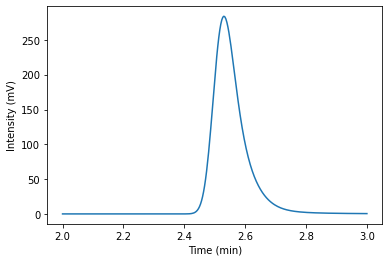

In [7]:
# Define the function
def datachop(x, y,minx,maxx):
    boo1 = np.logical_and(x <= maxx, x >= minx)
    return x[boo1], y[boo1]

# Set the min and max value
minx =  2
maxx =  3

# Run the function and save the outputs
cutx, cuty = datachop(xdata1, ydata1, minx , maxx)
# Plot the results
plt.plot(cutx,cuty)
plt.xlabel("Time (min)")
plt.ylabel("Intensity (mV)")
plt.show()

The next step is to integrate under this peak. We will do this using the numpy trapz function, which uses the trapezoid rule to integrate the data. We could just say that `area = np.trapz(cuty, x=cutx)`, but we will write a bigger function to combine the two functions, first cutting the data down to a specific range and then integrating.

In [8]:
# Define the integration function
def integrate(x, y, minx, maxx):
    cutx, cuty = datachop(x, y, minx , maxx)
    return np.trapz(cuty,x=cutx)

# Run the integration function
area1 = integrate(xdata1, ydata1, minx, maxx)
# Print the results
print("Area = ", area1)


Area =  30.97862333333334


Now, let's import some data from a higher concentration and integrate that.

In [10]:
# Specify the new file
file2 = "50 uM caf trial 3 ch 01.ASC"

# Same as above but with ydata2 and file2
ydata2 = np.loadtxt(file2, skiprows=25, usecols=0, delimiter=",", comments="I")
ydata2 = ydata2/1000.

# We next need to generate the x-data based on the sampling rate and the length of this new data
rate = 5.0
xdata2 = np.arange(0, len(ydata2))/float(rate)/60.

# Calculate and print the new area
area2 = integrate(xdata2, ydata2, minx, maxx)
print("Area = ", area2)

Area =  95.11943166666667


Does this make sense? Let's take a look at both results plotted together.

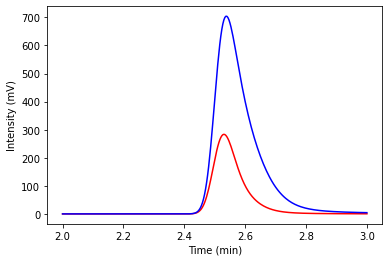

In [11]:
# Chop the data
x1, y1 = datachop(xdata1, ydata1, minx, maxx)
x2, y2 = datachop(xdata2, ydata2, minx, maxx)

# Plot the data
plt.plot(x1, y1, color="red")
plt.plot(x2, y2, color="blue")
plt.xlabel("Time (min)")
plt.ylabel("Intensity (mV)")
plt.show()


Now, let's plot the peak areas vs. their concentrations. I've created an array with concentration values and peak areas.

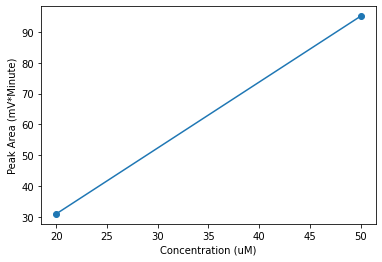

In [12]:
# Create an array using square brackets and the concentration values that you used
concs = [20, 50]
# Create a second array with the areas you calculated above
areas = [area1, area2]

# Plot the values
plt.plot(concs, areas, marker="o")
plt.xlabel("Concentration (uM)")
plt.ylabel("Peak Area (mV*Minute)")
plt.show()

To generate a calibration curve, we use the numpy polyfit command, which does a polynomial fit to the linear data. We can then take the fit slope and intercept and generate a linear curve to see how well it matches the data.

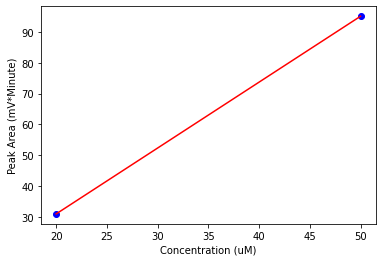

In [13]:
# Generate the fit using a first order polynomial (a line)
fit = np.polyfit(concs,areas,1)
# Extract the Slope from the fit array
fit_slope = fit[0]
# Extract the intercept from the fit array
fit_intercept = fit[1]

# Generate the simulated data from the fit
fit_ydata = fit_slope * np.array(concs) + fit_intercept

# Plot the experimental data as blue dots
plt.plot(concs, areas, linestyle = 'None', marker = "o", color="blue")
# Plot the fit as a red line
plt.plot(concs, fit_ydata, color="red")
plt.xlabel("Concentration (uM)")
plt.ylabel("Peak Area (mV*Minute)")
plt.show()

# Some Other Useful Functions

The code above shows you how to import data, integrate peaks, and create a calibration curve. This next block of code with show some useful functions that you will also need in your code. 

In [19]:
# Calculate the Mean of an Array
a = np.array([1, 2, 3, 4, 5])
mean = np.mean(a)
print("Mean = ", mean)

# Calculate the Standard Deviation
stddev = np.std(a, ddof=1)
print("Standard Deviation = ", stddev)

# Square an array
sq_a = a**2
print("Squared: ", sq_a)

# Take the Square Root of an array
sr_a = np.sqrt(a)
print("Square Root:", sr_a)

# Do other math operations on an array
cala = (a-fit_intercept)/fit_slope
print("A Calc:", cala)


Mean =  3.0
Standard Deviation =  1.5811388300841898
Squared:  [ 1  4  9 16 25]
Square Root: [1.         1.41421356 1.73205081 2.         2.23606798]
A Calc: [5.97836972 6.44609068 6.91381163 7.38153258 7.84925354]


# Wrapping Up
Now that you have seen the basic Python functions for importing and working with data. Use the space below to complete the assignment from the lab manual with your data. Again, make sure all the .ASC files are in the same folder on the hard drive as this .ipynb file.

After you are done, export this as a PDF by doing File > Print Preview. This will launch a print preview page. Then, you can click Ctrl+P or File > Print on your web browser and print to PDF. Turn in the PDF as your lab report. Good luck!

# Your Code Below

In [ ]:
# Your code here